## Making a regression model with mean and variance as outputs

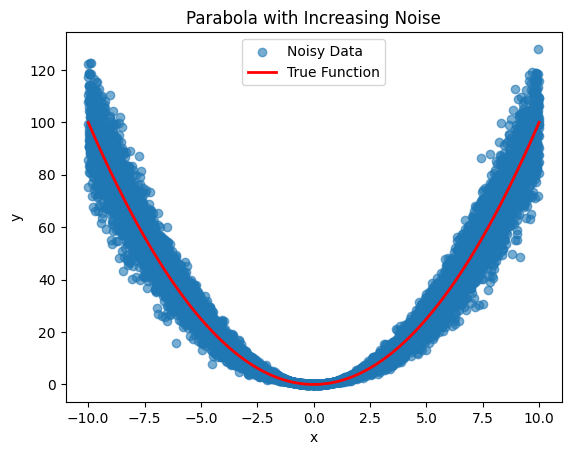

In [55]:
import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate x values
x = torch.linspace(-10, 10, 10000).reshape(-1, 1)

# Generate y values as a parabola with increasing noise
y_true = x**2
noise = torch.randn_like(x) * (0.1 + 0.5*torch.log(x.abs()) * (x.abs()))  # Increasing noise
y_noisy = y_true + noise

# Plot the dataset
plt.scatter(x.numpy(), y_noisy.numpy(), label="Noisy Data", alpha=0.6)
plt.plot(x.numpy(), y_true.numpy(), label="True Function", color='red', linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Parabola with Increasing Noise")
plt.show()

# Save dataset
dataset = (x, y_noisy)


In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UncertaintyRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(UncertaintyRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, 1)  # Outputs mean (mu)
        self.fc_var = nn.Linear(hidden_dim, 1)   # Outputs log variance (log(sigma^2))

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mean(x)   # Mean prediction
        log_var = self.fc_var(x)  # Log-variance prediction
        var = torch.exp(log_var)  # Ensure variance is positive
        return mu, var

In [57]:
# Negative log liklihood loss
def nll_loss(y_pred, y_true):
    mu, var = y_pred  # Extract mean and variance
    loss = 0.5 * torch.mean((y_true - mu) ** 2 / var + torch.log(var))
    return loss

In [58]:
# Example Training
model = UncertaintyRegression(input_dim=1, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x_train, y_train = dataset

for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = nll_loss(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Get model predictions
with torch.no_grad():
    mu_pred, var_pred = model(x)  # Get mean and variance predictions
    std_pred = torch.sqrt(var_pred)  # Standard deviation

Epoch 0: Loss = 1805.4630
Epoch 100: Loss = 2.6983
Epoch 200: Loss = 2.1441
Epoch 300: Loss = 1.7729
Epoch 400: Loss = 1.5927
Epoch 500: Loss = 1.5102
Epoch 600: Loss = 1.4523
Epoch 700: Loss = 1.4311
Epoch 800: Loss = 1.3958
Epoch 900: Loss = 1.3802


In [69]:
import scipy

dist_vals = scipy.stats.norm(mu_pred, scale=std_pred).ppf([0.1, 0.5, 0.9])
y_low, y_mean, y_high = dist_vals[:,0], dist_vals[:,1], dist_vals[:,2]

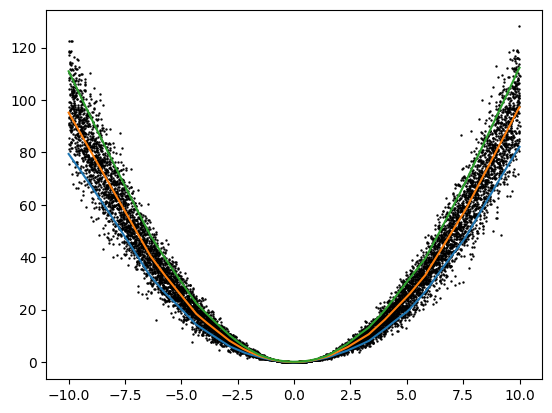

In [70]:
plt.scatter(x_train, y_train, s=0.5, color='black')
plt.plot(x_train, y_low)
plt.plot(x_train, y_mean)
plt.plot(x_train, y_high)